### Unoptimized model for topic, subtopic, and sentiment


In [1]:
# import useful stuff
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from gensim import corpora, models, similarities
from utils.cheaters import dctConstr
from utils.testing import train_test_split
# download lots of models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, plot_roc_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8jwa1eic because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df = pd.read_csv("ASRS_2022.csv", dtype={"label": "string", "narrative": "string"})
df.dropna(inplace=True)
    
dct = dctConstr(
    stop_words=["i", "you", "a", "but", "in", "of", "this", "no", "was", "to", "for", "it", "at", "the", "and", "we"], 
    ignore_case=True)
for chat in df.narrative.tolist():
    dct.constructor(chat)
    
dct.trimmer(min=25) # a term must occur 10 times or it gets cut
dct.build_tfidf(df.narrative.tolist())

#  save for the next exercise
with open("chat_parser.pkl", 'wb') as f:
    pickle.dump(dct, f, protocol=pickle.HIGHEST_PROTOCOL)

before trim number of terms: 9816
after trim: 1085
started building the idf


In [3]:
corp = df.narrative.tolist()
bow = [dct(chat) for chat in corp]
vec = [dct.bow_to_vec(p) for p in bow]
X = np.array(vec)

idx_to_terms = {i:j for j, i in dct.terms.items()} # flip dictionary for reversal
print(f"The corpus consists of {len(vec[0])} terms and {len(corp)} documents")

The corpus consists of 1085 terms and 998 documents


In [4]:
df["label"] = df["label"].astype("category")
print(df.label.cat.categories)

labels = {
    'ATC Equipment / Nav Facility / Buildings': 0,
    'Aircraft': 1,
    'Airport': 2,
    'Airspace Structure': 3,
    'Ambiguous': 4,
    'Chart Or Publication': 5,
    'Company Policy': 6,
    'Environment - Non Weather Related': 7,
    'Equipment / Tooling': 8,
    'Human Factors': 9,
    'Incorrect / Not Installed / Unavailable Part': 10,
    'MEL': 11,
    'Manuals': 12,
    'Procedure': 13,
    'Software and Automation':14,
    'Weather': 15
}
idx_lab = {i: j for j, i in labels.items()}
df["label_cat"] = df["label"].cat.rename_categories(labels)
Y = df["label_cat"].tolist()

Index(['ATC Equipment / Nav Facility / Buildings', 'Aircraft', 'Airport',
       'Airspace Structure', 'Ambiguous', 'Chart Or Publication',
       'Company Policy', 'Environment - Non Weather Related',
       'Equipment / Tooling', 'Human Factors',
       'Incorrect / Not Installed / Unavailable Part', 'MEL', 'Manuals',
       'Procedure', 'Software and Automation', 'Weather'],
      dtype='object')


In [5]:
#  let's save the idx to topic dictionaries for our next exercise
with open("/tmp/idx_lab.pkl", 'wb') as f:
    pickle.dump(idx_lab, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
clf_t = LogisticRegression(max_iter=1000)  # note that I had to increase the iterations for convergence
clf_t.fit(X, Y)
pred_t = clf_t.predict(X)

In [7]:
print(classification_report(Y, pred_t, target_names=list(labels.keys())))

                                              precision    recall  f1-score   support

    ATC Equipment / Nav Facility / Buildings       0.00      0.00      0.00        14
                                    Aircraft       0.45      1.00      0.62       437
                                     Airport       0.00      0.00      0.00        16
                          Airspace Structure       0.00      0.00      0.00         6
                                   Ambiguous       0.33      0.01      0.02       124
                        Chart Or Publication       0.00      0.00      0.00         3
                              Company Policy       0.00      0.00      0.00         6
           Environment - Non Weather Related       1.00      0.01      0.03        68
                         Equipment / Tooling       0.00      0.00      0.00         4
                               Human Factors       0.81      0.08      0.15       213
Incorrect / Not Installed / Unavailable Part       0.

/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model here scores badly. It may benefit from term reduction.

In [8]:
# Be warned this can take a while...
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
selector = RFECV(clf_t, 
                 step=20, # features to remove at each step
                 cv=StratifiedKFold(2), scoring="accuracy")
selector = selector.fit(X, Y)

/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


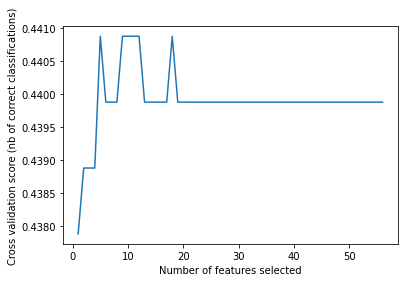

1085
term: tell
	 rank: 52
term: every
	 rank: 52
term: case
	 rank: 52
term: )
	 rank: 52
term: believed
	 rank: 52
term: try
	 rank: 52
term: things
	 rank: 52
term: alt
	 rank: 52
term: want
	 rank: 52
[52 11 21 25 12 13  4 31 47 15]
65


In [9]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

print(len(idx_to_terms))
rank = sorted([(i, j) for i, j in enumerate(selector.ranking_)], key=lambda x: x[1], reverse=True)
for idx, r in rank[1:10]:
    print(f"term: {idx_to_terms[idx]}\n\t rank: {r}")
print(selector.ranking_[:10])
print(selector.n_features_)

### Save & restore the model

In [10]:
# let's save our models an then load them
with open("/tmp/label_model.pkl", 'wb') as f:
    pickle.dump(clf_t, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('/tmp/label_model.pkl', 'rb') as f:
    clf_t = pickle.load(f)

In [12]:
phrase = "the airplane was on fire and atc didn't help"
doc_vec = [dct.bow_to_vec(dct(phrase))]  # the scikit models expect a list/array
print(dct(phrase)) # have a look to verify our test phrase contains something
print([idx_to_terms[i] for i, j in dct(phrase)]) # second reality check...

[(25, 0.22906426722706824), (56, 0.02943195272867756), (57, 0.3520147888797482), (69, 0.35890080342515923), (178, 0.33314911430645294), (425, 0.18222042811816969), (472, 0.4366581681340707)]
['t', 'on', 'airplane', 'fire', 'didn', 'atc', 'help']


In [13]:
def predictor(string):
    doc_vec = [dct.bow_to_vec(dct(string))]
    lab = clf_t.predict(doc_vec)[0]
    return f"label:\t\t{idx_lab[lab]}"

In [14]:
print(predictor(phrase))

label:		Aircraft


### Exercise 09
- remove the useless terms from the model
- rebuild the dictionary of terms
- rebuild the label model
- construct a filter to remove the useless terms for the model from the document vector
- rebuild the model